In [2]:
import xgboost as xgb
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [4]:
X, y = make_regression(n_samples=500, n_features=1, noise=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [5]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.2f}")

MSE: 191.33


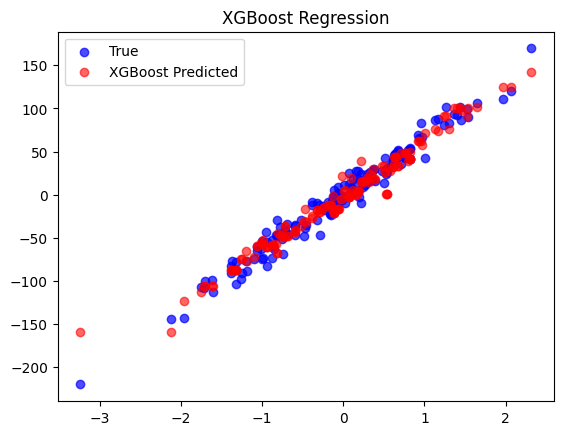

In [6]:
plt.scatter(X_test, y_test, label="True", color="blue", alpha=0.7)
plt.scatter(X_test, y_pred, label="XGBoost Predicted", color="red", alpha=0.6)
plt.legend()
plt.title("XGBoost Regression")
plt.show()

## Manual

In [8]:
import numpy as np 
from sklearn.datasets import make_regression 
import matplotlib.pyplot as plt

After estimator 1, Sample prediction head: [ 4.15396006  4.15396006 -8.67628709  4.15396006 -8.67628709]
After estimator 2, Sample prediction head: [  8.51836967   8.51836967 -16.58123549   8.51836967  -4.31187748]
After estimator 3, Sample prediction head: [ 14.75787104  14.75787104 -21.29656636  14.75787104  -9.02720835]
After estimator 4, Sample prediction head: [ 22.9286544   22.9286544  -24.33684725  22.9286544  -12.06748924]
After estimator 5, Sample prediction head: [ 25.80774856  25.80774856 -32.27131405  25.80774856  -9.18839508]
After estimator 6, Sample prediction head: [ 33.79363099  23.40359886 -34.67546375  33.79363099 -11.59254478]
After estimator 7, Sample prediction head: [ 36.73479912  26.34476698 -40.62126619  36.73479912  -8.65137666]
After estimator 8, Sample prediction head: [ 39.02773774  28.63770561 -46.94251018  39.02773774  -6.35843803]
After estimator 9, Sample prediction head: [ 46.4842765   26.81284498 -48.76737081  37.20287711  -8.18329866]
After estimator

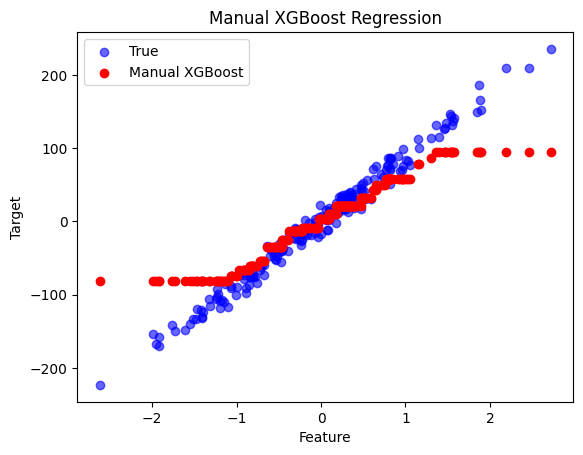

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

# Simple Decision Stump Regressor as Weak Learner
class DecisionStumpXGB:
    def fit(self, X, gradient, hessian, lam=1):
        # X is the 1D feature array (only one feature is being considered here)
        # gradient is the first order derivative of the loss function wrt the predictions for each sample
        # hessian is the second order derivative of the loss wrt predictions for each sample
        # lam=1 is the regularization parameter to avoid overfitting by penalizing very large leaf weights
        n = len(X)  # number of samples
        best_gain = -float('inf') # initialize the best split gain 
        best_thresh = None        # stores the best threshold (split point)
        best_left_val = None      # both store the optimal prediction values for left and right nodes after the split
        best_right_val = None

        # try all split points (midpoints between unique values)
        # for a decision stump, each unique feature value is considered as a potential split threshold
        for t in np.unique(X):
            left = X <= t # samples where feature <= threshold
            right = ~left # samples where feature > threshold 
            # skip if all samples go to one side
            if left.sum() == 0 or right.sum() == 0:
                continue
            
            # for xgboost, optimal leaf weight:
            # -sum(gradient) / [sum(hessian) + lambda]
            # This uses both first- and second-order derivatives for optimal split, as XGBoost does

            G_left, H_left = gradient[left].sum(), hessian[left].sum()
            w_left = -G_left / (H_left + lam)
            G_right, H_right = gradient[right].sum(), hessian[right].sum()
            w_right = -G_right / (H_right + lam)

            # gain formula (split gain)
            # measures how much the loss is reduced by splitting here
            # This is the improvement in loss due to this particular split
            gain = 0.5 * (
                (G_left ** 2) / (H_left + lam) + 
                (G_right ** 2) / (H_right + lam) - 
                (gradient.sum() ** 2) / (hessian.sum() + lam)
            )

            # keep track of the split that gives the maximum gain
            if gain > best_gain:
                best_gain = gain
                best_thresh = t
                best_left_val = w_left
                best_right_val = w_right

        # store the best split found during fitting
        self.threshold = best_thresh
        self.left_value = best_left_val
        self.right_value = best_right_val

    def predict(self, X):
        # for each sample, predict left_value if <= threshold, right_value otherwise
        return np.where(X <= self.threshold, self.left_value, self.right_value)
    

# XGBoost-like regression manually with decision stumps 
class SimpleXGBoostRegressor:
    def __init__(self, n_estimators=20, learning_rate=0.1, reg_lambda=1):
        # n_estimators: number of boosting rounds (trees to fit sequentially)
        # learning_rate: size of each boosting step
        # reg_lambda: regularization parameter for leaf weights
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.reg_lambda = reg_lambda
        self.stumps = []        # will hold our fitted weak learners
        self.y_mean = 0         # mean of y, used for initial prediction

    def fit(self, X, y):
        # flatten feature matrix for consistency (since we're only working with one feature here)
        X = X.flatten()
        self.y_mean = np.mean(y)                        # initial prediction is mean of y
        y_pred = np.full_like(y, self.y_mean, dtype=float)  # start with all predictions as mean

        for i in range(self.n_estimators):
            # gradient: for squared error loss, derivative wrt prediction is 2*(y_pred - y)
            grad = 2 * (y_pred - y)
            # hessian: for squared error, always 2
            hess = 2 * np.ones_like(grad)
            # fit a decision stump to the current gradients/hessians
            stump = DecisionStumpXGB()
            stump.fit(X, grad, hess, self.reg_lambda)
            # predict the updates (step to take for each sample)
            update = stump.predict(X)
            # update the predictions: move in direction of new tree's output scaled by learning rate
            y_pred += self.learning_rate * update
            # store the fitted stump
            self.stumps.append(stump)
            # print progress for tracing model growth
            print(f"After estimator {i+1}, Sample prediction head:", y_pred[:5])

    def predict(self, X):
        # flatten incoming features for consistency
        X = X.flatten()
        # start prediction from the mean of y
        y_pred = np.full_like(X, self.y_mean, dtype=float)
        # add boosting updates from each tree sequentially
        for i, stump in enumerate(self.stumps):
            # for each fitted stump, add its prediction scaled by learning rate
            y_pred += self.learning_rate * stump.predict(X)
            # print partial prediction for debugging if desired
            # print(f"Prediction after stump {i+1}:", y_pred[:5])
        # final prediction is the sum
        return y_pred

# Generate regression data (synthetic, single feature)
X, y = make_regression(n_samples=200, n_features=1, noise=10, random_state=42)

# create and fit the manual XGBoost-like model
model = SimpleXGBoostRegressor(n_estimators=20, learning_rate=0.1, reg_lambda=1)
model.fit(X, y)   # this fits n_estimators sequential stumps to the data

# predict on training data (since synthetic and for illustration)
y_pred = model.predict(X)

# Mean Squared Error (MSE): average squared difference between pred and true values
mse = np.mean((y - y_pred) ** 2)
# Mean Absolute Error (MAE): average absolute difference
mae = np.mean(np.abs(y - y_pred))
# R-squared (Coefficient of Determination): measure of fit quality
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2 = 1 - ss_res / ss_tot

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared: {r2:.3f}")

# --- Plotting results ---
plt.scatter(X, y, label="True", color="blue", alpha=0.6)  # true data points
plt.scatter(X, y_pred, label="Manual XGBoost", color="red")  # model predictions
plt.legend()
plt.title("Manual XGBoost Regression")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.show()
